<a href="https://colab.research.google.com/github/ramin40/ASL-recognition-with-CNN/blob/main/Deep_Q_network_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing necessary libraries

* clone github repository

In [ ]:
! git clone https://github.com/openai/baselines.git
%cd baselines
! git pull original master
! pip install requirements.text
! python setup.py install 

* importing roms

In [ ]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars

In [3]:
from baselines.common.atari_wrappers import make_atari,wrap_deepmind
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import keras
from keras import layers
import matplotlib.pyplot as plt
import time 
import pprint
from collections import deque

# defining constants

In [4]:
seed=123
max_step_per_episode=10000
max_reply_memory=100000
min_eps=0.1
max_eps=1.0
interval_eps=min_eps-max_eps
gamma=0.99
epsilon=1.0
batch_size=64
env = make_atari("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

[123, 151010689]

* inspecting environment

state shape(84, 84, 4), reward: 0.0


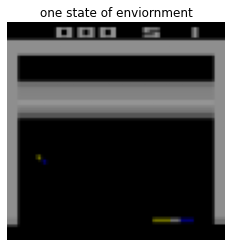





'in state matrix max value is 0.5803921818733215 and min value is 0.0'


In [5]:
env.reset()
state,reward,done,inf=env.step(1)
state_shape=np.array(state).shape
print(f'state shape{state_shape}, reward: {reward}')
state,reward,done,inf=env.step(1)
plt.imshow(np.array(state)[:,:,:3],cmap='gray')
plt.title('one state of enviornment')
plt.axis('off')
plt.show()
print('\n\n\n')
pprint.pprint(f'in state matrix max value is {np.max(state)} and min value is {np.min(state)}',)

# creating deep Q network
* this sections we will create Q and target(Q*) networks 

In [6]:
num_actions=env.action_space.n

def create_q_model():

    inputs = layers.Input(shape=(84, 84, 4,))
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)
Q_network=create_q_model()
Qstar_network=create_q_model()
Q_network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1606144   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052  

# training agent

In [10]:
def get_apply_grad_fn():
    @tf.function
    def apply_grad(network,optimizer,loss_fn,mask,data,target):
        with tf.GradientTape() as tape:
          perdiction=network(data)
          # applying mask
          selected_actions_for_correction=tf.reduce_sum(
          tf.multiply(perdiction,mask),axis=1)
          # calculating loss
          loss=loss_fn(target,selected_actions_for_correction)
        
        grades=tape.gradient(loss,network.trainable_variables)
        optimizer.apply_gradients(zip(grades,network.trainable_variables))

        return loss
    return apply_grad
train_step=get_apply_grad_fn()


In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025, clipnorm=1.0)
loss_fn=keras.losses.Huber()
empty_array=np.zeros(max_reply_memory)
running_reward=0
episode_counter=0
frame_counter=0

# replay memory
memory_of_actions=[]
memory_of_rewards=[]
memory_of_states=[]
memory_of_next_state=[]
memory_of_done=[]
episode_reward_history=[]
running_reward_history=deque(np.zeros(1000),maxlen=1000)
# defining exploration parameters 
epsilon_correction_rate=1000000.0
inital_exploration=50000
# training_period
training_period=4
# updating target networke
updating_period=1000

#training loop
while True:

  state=env.reset()
  state=np.array(state)
  episode_reward=0
  for episode in range(1,max_step_per_episode):
    frame_counter+=1

    # geedy epsilon policy
    if frame_counter<inital_exploration or epsilon>np.random.rand(1)[0]:
      action=np.random.choice(num_actions)
    else:
      state_tensor=tf.convert_to_tensor(state)
      state_tensor=tf.expand_dims(state_tensor,0)
      action_probs=Q_network(state_tensor,training=True)
      action=np.argmax(action_probs[0]).numpy()

    # epsilon correction for naxt time step exploration
    epsilon-=interval_eps/epsilon_correction_rate
    epsilon=max(epsilon,min_eps)

    # take step in environment
    next_state,reward,done,_=env.step(action)
    next_state=np.array(next_state)
    episode_reward+=reward
    state=next_state
    # creating replay buffer
    memory_of_actions.append(action)
    memory_of_done.append(done)
    memory_of_next_state.append(next_state)
    memory_of_rewards.append(reward)
    memory_of_states.append(state)

    # training target network
    if frame_counter % updating_period==0 and len(memory_of_rewards)>batch_size:
      # selecting random experiences for removing data dependencie
      indices=np.random.choice(range(len(memory_of_states)),batch_size)

      sampled_states=np.array([memory_of_states[i] for i in indices ])
      sampled_next_states=np.array([memory_of_next_state[i] for i in indices])
      sampled_rewards=[memory_of_rewards[i] for i in indices]
      sampled_actions=[memory_of_actions[i] for i in indices]
      # tip: float(True)=1.0 and float(False)=0.0
      sampled_dons=tf.convert_to_tensor([float(memory_of_done[i]) for i in indices])

      # calculating Q^*(next_state): output of target network
      q_star_next_state=Qstar_network.predict(sampled_next_states)

      # calculating Q^*(state): Q(s)=reward(s) + discounte factor*max(Q(s+1))
      q_star_state=sampled_rewards+ gamma*tf.reduce_max(q_star_next_state,
                                                        axis=1)
      # setting value of last state to -1
      q_star_state=q_star_state * (1 - sampled_dons) - sampled_dons

      # creating mask for updating just selected actions(updating weights of 
      # neurun with highest Q value )
      mask=tf.one_hot(sampled_actions,num_actions)

      # training Q_network
      train_step(Q_network,optimizer,loss_fn,mask,sampled_states,q_star_state) 
      
    #updating target network
    if frame_counter % updating_period==0:
      Qstar_network.set_weights(Q_network.get_weights())
      if frame_counter%10000==0:
        print(f'in episode {episode_counter} agent has seen {frame_counter} frames and running reward is:{running_reward}')
   
    # reducing memory size
    if len(memory_of_rewards) > max_reply_memory:
      
      del memory_of_rewards[:1]
      del memory_of_states[:1]
      del memory_of_next_state[:1]
      del memory_of_actions[:1]
      del memory_of_done[:1]

    if done :
      break
  episode_counter+=1
  episode_reward_history.append(episode_reward)
  if len(episode_reward_history) > 100:

    del episode_reward_history[:1]

  running_reward=np.mean(episode_reward_history)
  running_reward_history.append(running_reward)

  if running_reward > 40:  # Condition to consider the task solved
      print("Solved at episode {}!".format(episode_counter))
      break


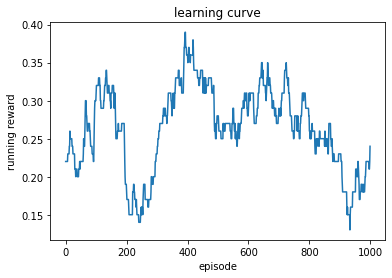

In [14]:
plt.plot(range(len(running_reward_history)),running_reward_history)
plt.title('learning curve')
plt.xlabel('episode')
plt.ylabel('running reward')
plt.show()

## Visualizations
Before any training:
![Imgur](https://i.imgur.com/rRxXF4H.gif)

In early stages of training:
![Imgur](https://i.imgur.com/X8ghdpL.gif)

In later stages of training:
![Imgur](https://i.imgur.com/Z1K6qBQ.gif)